# Residual Networks

In this notebook, you will learn how to build very deep convolutional networks using Residual Networks (ResNets). In theory, very deep networks can represent very complex functions; but in practice, they are hard to train. Residual Networks, introduced by [He et al.](https://arxiv.org/pdf/1512.03385.pdf), allow you to train much deeper networks than were previously practically feasible.

**In this assignment, you will:**
- Implement the basic building blocks of ResNets. 
- Put together these building blocks to implement and train a state-of-the-art neural network for image classification. 

This assignment will be done in PyTorch. 

Before jumping into the problem, let's run the cell below to load the required packages.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from resnets_utils import *

from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import h5py
from matplotlib import pyplot as plt

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.cuda.manual_seed_all(1337)
torch.manual_seed(1337)

## 1 - The problem of very deep neural networks

In recent years, neural networks have become deeper, with state-of-the-art networks going from just a few layers (e.g., AlexNet) to over a hundred layers.

The main benefit of a very deep network is that it can represent very complex functions. It can also learn features at many different levels of abstraction, from edges (at the lower layers) to very complex features (at the deeper layers). However, using a deeper network doesn't always help. A huge barrier to training them is vanishing gradients: very deep networks often have a gradient signal that goes to zero quickly, thus making gradient descent unbearably slow. More specifically, during gradient descent, as you backprop from the final layer back to the first layer, you are multiplying by the weight matrix on each step, and thus the gradient can decrease exponentially quickly to zero (or, in rare cases, grow exponentially quickly and "explode" to take very large values). 

During training, you might therefore see the magnitude (or norm) of the gradient for the earlier layers descrease to zero very rapidly as training proceeds: 

<img src="images/vanishing_grad_kiank.png" style="width:450px;height:220px;">
<caption><center> <u> <font color='purple'> **Figure 1** </u><font color='purple'>  : **Vanishing gradient** <br> The speed of learning decreases very rapidly for the early layers as the network trains </center></caption>

You are now going to mitigate this problem by building a Residual Network!

## 2 - Building a Residual Network

In ResNets, a "shortcut" or a "skip connection" allows the gradient to be directly backpropagated to earlier layers:  

<img src="images/skip_connection_kiank.png" style="width:650px;height:200px;">
<caption><center> <u> <font color='purple'> **Figure 2** </u><font color='purple'>  : A ResNet block showing a **skip-connection** <br> </center></caption>

The image on the left shows the "main path" through the network. The image on the right adds a shortcut to the main path. By stacking these ResNet blocks on top of each other, you can form a very deep network. 

We also saw in lecture that having ResNet blocks with the shortcut also makes it very easy for one of the blocks to learn an identity function. This means that you can stack on additional ResNet blocks with little risk of harming training set performance. (There is also some evidence that the ease of learning an identity function--even more than skip connections helping with vanishing gradients--accounts for ResNets' remarkable performance.)

Two main types of blocks are used in a ResNet, depending mainly on whether the input/output dimensions are same or different. You are going to implement both of them. 

### 2.1 - The identity block

The identity block is the standard block used in ResNets, and corresponds to the case where the input activation (say $a^{[l]}$) has the same dimension as the output activation (say $a^{[l+2]}$). To flesh out the different steps of what happens in a ResNet's identity block, here is an alternative diagram showing the individual steps:

<img src="images/idblock2_kiank.png" style="width:650px;height:150px;">
<caption><center> <u> <font color='purple'> **Figure 3** </u><font color='purple'>  : **Identity block.** Skip connection "skips over" 2 layers. </center></caption>

The upper path is the "shortcut path." The lower path is the "main path." In this diagram, we have also made explicit the CONV2D and ReLU steps in each layer. To speed up training we have also added a BatchNorm step. Don't worry about this being complicated to implement--you'll see that BatchNorm is just one line of code in Pytorch! 

In this exercise, you'll actually implement a slightly more powerful version of this identity block, in which the skip connection "skips over" 3 hidden layers rather than 2 layers. It looks like this: 

<img src="images/idblock3_kiank.png" style="width:650px;height:150px;">
<caption><center> <u> <font color='purple'> **Figure 4** </u><font color='purple'>  : **Identity block.** Skip connection "skips over" 3 layers.</center></caption>

Here're the individual steps.

First component of main path: 
- The first CONV2D has $F_1$ filters of shape (1,1) and a stride of (1,1). Its padding is "valid". 
- The first BatchNorm is normalizing the channels axis.
- Then apply the ReLU activation function. This has no name and no hyperparameters. 

Second component of main path:
- The second CONV2D has $F_2$ filters of shape $(f,f)$ and a stride of (1,1). Its padding is "same".  
- The second BatchNorm is normalizing the channels axis.
- Then apply the ReLU activation function. This has no name and no hyperparameters. 

Third component of main path:
- The third CONV2D has $F_3$ filters of shape (1,1) and a stride of (1,1). Its padding is "valid". 
- The third BatchNorm is normalizing the channels axis. Note that there is no ReLU activation function in this component. 

Final step: 
- The shortcut and the input are added together.
- Then apply the ReLU activation function. This has no name and no hyperparameters. 

**Exercise**: Implement the ResNet identity block. We have implemented the first component of the main path. Please read over this carefully to make sure you understand what it is doing. You should implement the rest. 
- To implement the Conv2D step: [See reference](https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d)
- To implement BatchNorm: [See reference](https://pytorch.org/docs/stable/nn.html#torch.nn.BatchNorm2d)
- For the activation, use: `nn.ReLU()`

In [3]:
# GRADED CLASS: identity_block
# identity block doesn't change input sizes and the number of channels.
class identity_block(nn.Module):    
    """
    Implementation of the identity block as defined in Figure 3

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    filters -- integer, specifying the shape of the middle CONV's window for the main path
    input_channels -- integer, specifying the number of channels in the input data, x

    Returns:
    x -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    def __init__(self, filters, input_channels):
        super().__init__()
        F1, F2 = filters
        #Set up the first component of the main path
        self.conv2d_1 = nn.Conv2d(in_channels=input_channels, out_channels=F1, kernel_size=1)
        self.bn_1 = nn.BatchNorm2d(F1)
        self.relu_1 = nn.ReLU()
        
        ### START CODE HERE ###
        
        # Set up the second component of the main path
        #3x3 same convolution, padding=1, stride=1
        self.conv2d_2 = nn.Conv2d(in_channels=F1, out_channels=F2, kernel_size=3, padding=1) #same convolution
        self.bn_2 = nn.BatchNorm2d(F2)
        self.relu_2 = nn.ReLU()
        
        #Set up the third component of the main path
        #we get back to the original channel size since we assume that the input from the shortcut path and
        #from the main path has the same number of channels when we are using an identity block.
        self.conv2d_3 = nn.Conv2d(in_channels=F2, out_channels=input_channels, kernel_size=1) #doesn't change input size
        self.bn_3 = nn.BatchNorm2d(input_channels)
        self.relu_3 = nn.ReLU()
        
        ### END CODE HERE ###
        
    def forward(self, x):
        #create shortcut which is simply the input
        x_shortcut = x
        #Apply the fist component of the main path declared above in __init__
        x = self.conv2d_1(x)
        x = self.bn_1(x)
        x = self.relu_1(x)
        ### START CODE HERE ###
        
        #Apply the second component of main path (≈3 lines)
        x = self.conv2d_2(x)
        x = self.bn_2(x)
        x = self.relu_2(x)
        
        #Apply the third component of main path (≈2 lines)
        x = self.conv2d_3(x)
        x = self.bn_3(x) 
        
        # Final step: Add shortcut value to main path and pass it through a RELU activation (≈2 lines)
        x += x_shortcut
        
        x = self.relu_3(x)
        ### END CODE HERE ###
        
        return x

## 2.2 - The convolutional block

You've implemented the ResNet identity block. Next, the ResNet "convolutional block" is the other type of block. You can use this type of block when the input and output dimensions don't match up. The difference with the identity block is that there is a CONV2D layer in the shortcut path: 

<img src="images/convblock_kiank.png" style="width:650px;height:150px;">
<caption><center> <u> <font color='purple'> **Figure 4** </u><font color='purple'>  : **Convolutional block** </center></caption>

The CONV2D layer in the shortcut path is used to resize the input $x$ to a different dimension, so that the dimensions match up in the final addition needed to add the shortcut value back to the main path. (This plays a similar role as the matrix $W_s$ discussed in lecture.) For example, to reduce the activation dimensions's height and width by a factor of 2, you can use a 1x1 convolution with a stride of 2. The CONV2D layer on the shortcut path does not use any non-linear activation function. Its main role is to just apply a (learned) linear function that reduces the dimension of the input, so that the dimensions match up for the later addition step. 

The details of the convolutional block are as follows. 

First component of main path:
- The first CONV2D has $F_1$ filters of shape (1,1) and a stride of (stide_size,stride_size). Its padding is "valid". 
- The first BatchNorm normalizes the channel axis. 
- Then apply the ReLU activation function. This has no hyperparameters. 

Second component of main path:
- The second CONV2D has $F_2$ filters of (f,f) and a stride of (1,1). Its padding is "same".
- The second BatchNorm is normalize the channel axis.
- Then apply the ReLU activation function. This has no hyperparameters. 

Third component of main path:
- The third CONV2D has $F_3$ filters of (1,1) and a stride of (1,1). Its padding is "valid".
- The third BatchNorm is normalizes the channels axis. Note that there is no ReLU activation function in this component. 

Shortcut path:
- The CONV2D has $F_3$ filters of shape (1,1) and a stride of (stride_size,stride_size). Its padding is "valid".
- The BatchNorm noramlizes the channel axis.

Final step: 
- The shortcut and the main path values are added together.
- Then apply the ReLU activation function. This has no hyperparameters. 
    
**Exercise**: Implement the convolutional block. We have implemented the first component of the main path; you should implement the rest.
- [Conv Hint](https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d)
- [BatchNorm Hint](https://pytorch.org/docs/stable/nn.html#torch.nn.BatchNorm2d)
- For the activation, use: `nn.ReLU()`

In [4]:
# GRADED CLASS: convolutional_block


class convolutional_block(nn.Module):
    """
    Implementation of the convolutional block as defined in Figure 4

    Arguments:
    x -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stide_size -- Integer, specifying the stride to be used
    input_channels -- Integer, specifying the number of channels in the input data, x

    Returns:
    x -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    def __init__(self, filters, stride_size, input_channels):
        super().__init__()
        
        # Retrieve Filters
        F1, F2, F3 = filters
        ######MAIN PATH#####
        #Set up first component of the main path
        self.conv2d_1 = nn.Conv2d(in_channels=input_channels, out_channels=F1, kernel_size=1, stride=stride_size)
        self.bn_1 = nn.BatchNorm2d(F1)
        self.relu_1 = nn.ReLU()
        
        ###START CODE HERE###
        #Set up second component of main path (≈3 lines)
        #3x3 same convolution, padding=1, stride =1
        self.conv2d_2 = nn.Conv2d(in_channels=F1, out_channels=F2, kernel_size=3, padding=1) 
        self.bn_2 = nn.BatchNorm2d(F2)
        self.relu_2 = nn.ReLU()
        
        #Set up third component of main path (≈2 lines)
        #1x1 valid convolution, padding=0, stride =1
        self.conv2d_3 = nn.Conv2d(in_channels=F2, out_channels=F3, kernel_size=1)
        self.bn_3 = nn.BatchNorm2d(F3)
        
        ###END CODE HERE###
        
        #####SHORTCUT PATH#####
        #After this, input sizes and the number of channels will match. Because this convolution applies the only 
        #transformation that affects the input size, the key point here is stride=stride_size. The output channels are equal
        #to the number of output channels of the main path. 
        self.conv2d_shortcut = nn.Conv2d(in_channels=input_channels, 
                                         out_channels=F3, 
                                         kernel_size=1, 
                                         stride=stride_size)
        self.bn_shortcut = nn.BatchNorm2d(F3)     
        self.relu_3 = nn.ReLU()
        
        
    def forward(self, x):
        #create shortcut which is simply the input
        x_shortcut = x
        
        ####MAIN PATH####
        #Apply the fist component of the main path declared above in __init__        
        x = self.conv2d_1(x)
        x = self.bn_1(x)
        x = self.relu_1(x)
        ###START CODE HERE###
        
        #Apply the second component (≈3 lines)
        x = self.conv2d_2(x)
        x = self.bn_2(x)
        x = self.relu_2(x)
        
        #Apply the third component (≈2 lines)
        x = self.conv2d_3(x)
        x = self.bn_3(x)
        
        ####SHORTCUT PATH#####
        #Apply convolution and batch norm to shortcut (≈2 lines)
        x_shortcut = self.conv2d_shortcut(x_shortcut)
        x_shortcut = self.bn_shortcut(x_shortcut)
        
        # Final step: Add shortcut value to main path and pass it through a RELU activation (≈2 lines)
        x += x_shortcut
        x = self.relu_3(x)
        ###END CODE HERE###
        
        return x

## 3 - Building your first ResNet model (50 layers)

You now have the necessary blocks to build a very deep ResNet. The following figure describes in detail the architecture of this neural network. "ID BLOCK" in the diagram stands for "Identity block," and "ID BLOCK x3" means you should stack 3 identity blocks together.

<img src="images/resnet_kiank.png" style="width:850px;height:150px;">
<caption><center> <u> <font color='purple'> **Figure 5** </u><font color='purple'>  : **ResNet-50 model** </center></caption>

The details of this ResNet-50 model are:
- Zero-padding pads the input with a pad of (3,3)
- Stage 1:
    - The 2D Convolution has 64 filters of shape (7,7) and uses a stride of (2,2).
    - BatchNorm is applied to the channels axis of the input.
    - MaxPooling uses a (3,3) window and a (2,2) stride.
- Stage 2:
    - The convolutional block uses three set of filters of size [64,64,256], "f" is 3, "stride_size" is 1.
    - The 2 identity blocks use three set of filters of size [64,64,256], "f" is 3.
- Stage 3:
    - The convolutional block uses three set of filters of size [128,128,512], "f" is 3, "stride_size" is 2.
    - The 3 identity blocks use three set of filters of size [128,128,512], "f" is 3.
- Stage 4:
    - The convolutional block uses three set of filters of size [256, 256, 1024], "f" is 3, "stride_size" is 2.
    - The 5 identity blocks use three set of filters of size [256, 256, 1024], "f" is 3.
- Stage 5:
    - The convolutional block uses three set of filters of size [512, 512, 2048], "f" is 3, "stride_size" is 2.
    - The 2 identity blocks use three set of filters of size [512, 512, 2048], "f" is 3.
- The 2D Average Pooling uses a window of shape (2,2).
- The Fully Connected (Linear) layer reduces its input to the number of classes using a softmax activation.

**Exercise**: Implement the ResNet with 50 layers described in the figure above. We have implemented Stages 1 and 2. Please implement the rest. (The syntax for implementing Stages 3-5 should be quite similar to that of Stage 2.) Make sure you follow the naming convention in the text above. Additionally, you need only use the the identity_block and convolutional_block classes defined above.

In [5]:
# GRADED MODEL: ResNet50
num_classes = 6
ResNet50 = nn.Sequential(
    #Zero Padding
    nn.ConstantPad2d(3, 0),
    #Stage 1
    nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2),
    nn.BatchNorm2d(64),
    nn.MaxPool2d(kernel_size=3, stride=2),
    #Stage 2 convolutation_block (CB) --> identity_block (IB) --> IB
    convolutional_block(filters=[64, 64, 256], stride_size=1, input_channels=64),
    identity_block(filters=[64, 64], input_channels=256),
    identity_block(filters=[64, 64], input_channels=256),
    ###START CODE HERE###
    #Stage 3 (≈4 lines)  CB --> IB --> IB --> IB
    convolutional_block(filters=[128, 128, 512], stride_size=2, input_channels=256),
    identity_block(filters=[128, 128], input_channels=512),
    identity_block(filters=[128, 128], input_channels=512),
    identity_block(filters=[128, 128], input_channels=512),
    #Stage 4(≈6 lines) CB --> IB --> IB --> IB --> IB --> IB
    convolutional_block(filters=[256, 256, 1024], stride_size=2, input_channels=512),
    identity_block(filters=[256, 256], input_channels=1024),
    identity_block(filters=[256, 256], input_channels=1024),
    identity_block(filters=[256, 256], input_channels=1024),
    identity_block(filters=[256, 256], input_channels=1024),
    identity_block(filters=[256, 256], input_channels=1024),
    #Stage 5(≈3 lines) CB --> IB --> IB
    convolutional_block(filters=[512, 512, 2048], stride_size=2, input_channels=1024),
    identity_block(filters=[512, 512], input_channels=2048),
    identity_block(filters=[512, 512], input_channels=2048),
    ###END CODE HERE###
    nn.AvgPool2d(kernel_size=2), #outputs 1x1x2048
    nn.Flatten(),
    nn.Linear(2048, num_classes)
).to(device)

Great! As always, let's use cross entropy loss and Adam to optimize our network.

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ResNet50.parameters(), lr=1e-3)

The model is now ready to be trained. The only thing you need is a dataset.

Let's load the SIGNS Dataset.

<img src="images/signs_data_kiank.png" style="width:450px;height:250px;">
<caption><center> <u> <font color='purple'> **Figure 6** </u><font color='purple'>  : **SIGNS dataset** </center></caption>


In [7]:
X_train_orig, Y_train, X_test_orig, Y_test, classes = load_dataset()

#swap axes to Pytorch convention
X_train_orig = np.transpose(X_train_orig, (0, 3, 1, 2))
X_test_orig = np.transpose(X_test_orig, (0, 3, 1, 2))

#flatten to vectors
Y_train = Y_train.ravel()
Y_test = Y_test.ravel()

# Normalize image tensors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 3, 64, 64)
Y_train shape: (1080,)
X_test shape: (120, 3, 64, 64)
Y_test shape: (120,)


Let's now convert the numpy arrays to Pytorch tensors and then to Dataset objects. Hopefully you remember this from the first Pytorch assignment!

In [8]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.long)


train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)

Finally, we can change the dataset objects into Pytorch dataloaders and specify the batch size.

In [9]:
loader_train = DataLoader(train_dataset, batch_size=32, shuffle=True)
loader_test = DataLoader(test_dataset, batch_size=32, shuffle=True)

Run the following cell to train your model for 10 epochs. On my GPU, it takes about 1 minute. 

Epoch: 1 | Test Accuracy: 0.18333333333333332 | Train Accuracy: 0.1712962962962963
Epoch: 2 | Test Accuracy: 0.38333333333333336 | Train Accuracy: 0.42962962962962964
Epoch: 3 | Test Accuracy: 0.875 | Train Accuracy: 0.8685185185185185
Epoch: 4 | Test Accuracy: 0.8583333333333333 | Train Accuracy: 0.8777777777777778
Epoch: 5 | Test Accuracy: 0.85 | Train Accuracy: 0.9092592592592592
Epoch: 6 | Test Accuracy: 0.7333333333333333 | Train Accuracy: 0.8018518518518518
Epoch: 7 | Test Accuracy: 0.8416666666666667 | Train Accuracy: 0.8722222222222222
Epoch: 8 | Test Accuracy: 0.875 | Train Accuracy: 0.9185185185185185
Epoch: 9 | Test Accuracy: 0.8333333333333334 | Train Accuracy: 0.899074074074074
Epoch: 10 | Test Accuracy: 0.8166666666666667 | Train Accuracy: 0.8333333333333334
Epoch: 11 | Test Accuracy: 0.75 | Train Accuracy: 0.7666666666666667
Epoch: 12 | Test Accuracy: 0.9666666666666667 | Train Accuracy: 0.987037037037037
Epoch: 13 | Test Accuracy: 0.8 | Train Accuracy: 0.802777777777777

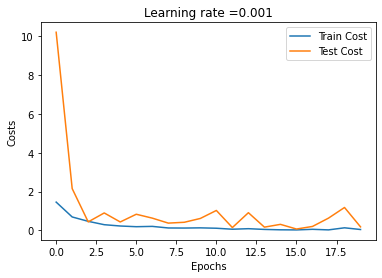

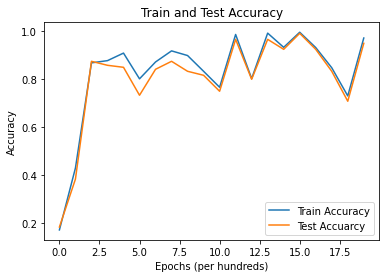

Wall time: 2min 32s


In [10]:
%%time
def train(model, criterion, optimizer, train_loader, test_loader, epochs=20):
    torch.manual_seed(1337)
    #Intialize empty lists to accumulate costs and accuracy values on each epoch
    train_costs, test_costs, test_accs, train_accs = [], [], [], []
    model = model.to(device)
    #Start training for loop. epoch is neural network jargon for iteration
    for epoch in range(epochs):
        
        #Optimization
        train_loss = 0.0
        model.train()
        for X, Y in train_loader:
            
            #Send X and Y to a given device for optimized parameter updates (CUDA or CPU)
            output, target = X.to(device), Y.to(device).view(-1)
            ###START CODE HERE###
            #Compute model's prediction of X (approx 1 line)
            output = model(output)
            #Compute the loss for the model's prediction and the true value of Y (approx 1 line)
            loss = criterion(output, target)
            #Add the train loss value to our train loss accumulator
            train_loss += loss.item()
            #Initialize gradient to zero (approx 1 line)
            optimizer.zero_grad()
            #Compute the derivative of the loss w.r.t each parameter via backprop (approx 1 line)
            loss.backward()
            #Use the optimizer to update parameters of neural network (approx 1 line)
            optimizer.step()
            ###END CODE HERE###
        #normalize loss by m_train and add to train_costs list
        train_costs.append(train_loss / len(train_loader))
        
        #Compute the test loss. The code below does not optimize. It is purely for plotting/comparison purposes.
        test_loss = 0.0
        with torch.no_grad():
            model.eval()
            for X, Y in test_loader:
                output, target = X.to(device), Y.to(device).view(-1) 
                ###START CODE HERE###
                #Compute model's guess for X (data) (approx 1 line)
                output = model(output)                
                #Compute loss of X and Y (approx 1 line)
                loss = criterion(output, target)
                #Add test loss of current batch to test loss accumulator (approx 1 line)
                test_loss += loss.item()
                ###END CODE HERE###
            #normalize loss by m_test and add to test_costs list
            test_costs.append(test_loss/len(test_loader))

        
      
        test_acc = get_accuracy(model, test_loader)
        test_accs.append(test_acc)
        train_acc = get_accuracy(model, train_loader)
        train_accs.append(train_acc)                            
        print('Epoch: {} | Test Accuracy: {} | Train Accuracy: {}'.format(epoch+1, test_acc, train_acc))
    
    #plotting
    #lr = get_lr(optimizer)
    plt.plot(train_costs, label ='Train Cost')
    plt.plot(test_costs, label ='Test Cost')
    plt.ylabel('Costs')
    plt.xlabel('Epochs')
    plt.title("Learning rate ={}".format(1e-3))
    plt.legend()
    plt.show()
    
    
    plt.plot(train_accs, label ='Train Accuracy')
    plt.plot(test_accs, label ='Test Accuarcy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs (per hundreds)')
    plt.title("Train and Test Accuracy")
    plt.legend()
    plt.show()
torch.manual_seed(1337)
train(ResNet50, criterion, optimizer, loader_train, loader_test)

Nice work! As you can see, our ResNet is no joke when it comes to image classification, which is why they are so highly used not only in computer vision, but also quantative biology because we can build super deep networks with millions of parameters and avoid the vanishing/exploding gradient problem. Finally, if you want to see just how big the network is, run the following cell to see a summary of our network.

Note: if the following cell crashes for you, try installing torchsummary in your anaconda prompt:
        
    pip install torchsummary

In [11]:
X_train.shape

(1080, 3, 64, 64)

In [12]:
from torchsummary import summary
print(summary(ResNet50, input_size=(X_train.shape[1:])))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
     ConstantPad2d-1            [-1, 3, 70, 70]               0
            Conv2d-2           [-1, 64, 32, 32]           9,472
       BatchNorm2d-3           [-1, 64, 32, 32]             128
         MaxPool2d-4           [-1, 64, 15, 15]               0
            Conv2d-5           [-1, 64, 15, 15]           4,160
       BatchNorm2d-6           [-1, 64, 15, 15]             128
              ReLU-7           [-1, 64, 15, 15]               0
            Conv2d-8           [-1, 64, 15, 15]          36,928
       BatchNorm2d-9           [-1, 64, 15, 15]             128
             ReLU-10           [-1, 64, 15, 15]               0
           Conv2d-11          [-1, 256, 15, 15]          16,640
      BatchNorm2d-12          [-1, 256, 15, 15]             512
           Conv2d-13          [-1, 256, 15, 15]          16,640
      BatchNorm2d-14          [-1, 256,

OMG! That's a lot of parameters. ^^

<font color='blue'>
**What you should remember:**
- Very deep "plain" networks don't work in practice because they are hard to train due to vanishing gradients.  
- The skip-connections help to address the Vanishing Gradient problem. They also make it easy for a ResNet block to learn an identity function. 
- There are two main type of blocks: The identity block and the convolutional block. 
- Very deep Residual Networks are built by stacking these blocks together.

### References 

This notebook presents the ResNet algorithm due to He et al. (2015). The implementation here also took significant inspiration and follows the structure given in the github repository of Francois Chollet: 

- Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun - [Deep Residual Learning for Image Recognition (2015)](https://arxiv.org/abs/1512.03385)
- Francois Chollet's github repository: https://github.com/fchollet/deep-learning-models/blob/master/resnet50.py
